# Evaluation of Madmom Beat-Detector $^{[1]}$
* Evaluate output of Madmom beat detector on filosax data and provided beat-information with mir_eval
* Create Visualisation of achieved F-score

[1] https://github.com/CPJKU/madmom

In [1]:
# install madmom first
#!pip install git+https://github.com/CPJKU/madmom
#!pip install pyfluidsynth==1.3.2

## Troubleshooting:
#for midi to audio you need numpy < 1.24.0 and a midi-sound font, we use open-source GeneralUser GS from http://www.schristiancollins.com/generaluser.php  
#!mamba install "numpy<1.24.0" -y # pretty midi needs an older numpy version, use conda or pip if you dont have mamba

In [24]:
import mir_eval
import mirdata
import madmom
import os
from glob import glob
from piano_transcription_utils import *
import logging
import numpy as np
import json
import librosa
import librosa.display
from pretty_midi import PrettyMIDI
import soundfile as sf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import pypianoroll
from tqdm import tqdm

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)#

## Initialize madmom-Downbeat-Processor

In [11]:
mom_act_processor = madmom.features.downbeats.RNNDownBeatProcessor()
mom_beat_processor = madmom.features.downbeats.DBNDownBeatTrackingProcessor(beats_per_bar=[3, 4], fps=100)

## Load audio files

In [12]:
# File loader is configured to load the Filosax dataset and combine sources for beat detection

PATH_TO_FILES = "audio/filosax/Backing" #relative filepath to filosax data
OUT_PATH = "audio/"  #relative filepath
RECURSIVE = True # set to True to include subfolders
FILETYPE1 = ["wav","mp3"] # filetype of audio files
FILETYPE2 = ["jams"] # filetype of annotation files
audio_files = get_files(PATH_TO_FILES,OUT_PATH,FILETYPE1,True)
annotation_files = get_files(PATH_TO_FILES,OUT_PATH,FILETYPE2,True)

### comment-out if you dont want to filter audio files by given substring
audio_files_ = []
substring = "Drums"
for i in range(len(audio_files)):
    if audio_files[i].find(substring) != -1:
        audio_files_.append(audio_files[i])
    else:
        continue
audio_files = audio_files_
###
assert len(audio_files) % len(annotation_files) == 0
logging.info(f"Valid audio and annotation files found: {len(audio_files)}")
audio_files, len(annotation_files)

INFO:Created output folders.
INFO:Found 3 audiofiles.
INFO:Created output folders.
INFO:Found 1 audiofiles.
INFO:Valid audio and annotation files found: 2


(['audio/filosax/Backing/01/Bass_Drums.wav',
  'audio/filosax/Backing/01/Piano_Drums.wav'],
 1)

In [13]:
# merge bass and piano
for i in range(0,len(audio_files),2):
    #if i == 2: break
    bass, sr = librosa.load(audio_files[i],sr =44100)
    piano, _ = librosa.load(audio_files[i+1],sr =44100)
    combined = (piano+bass)/2
    sf.write(os.path.join(os.path.dirname(audio_files[i]),'combined.wav'),combined,sr)
    

In [14]:
audio_files= sorted(glob(os.path.join(PATH_TO_FILES,"**",'*combined.wav')))
audio_files

['audio/filosax/Backing/01/combined.wav']

## Load Filosax-Annotations

In [15]:
annotations = []

filosax = mirdata.initialize('filosax', data_home="audio/filosax", version='full_sax_1.0')  

for i in tqdm(range(len(audio_files))):
    tune_num = i
    multi_ids = filosax.mtrack_ids
    filosax_data = filosax.load_multitracks()
    example_tune = filosax_data[multi_ids[tune_num]]
    downbeats = [beat.time for beat in example_tune.beats if beat.value == 1]
    annotations.append(downbeats)
len(annotations)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.12it/s]


1

## Make predictions with madmom

In [16]:
prediction_files=[]
for i,path in enumerate(audio_files):
    
    audio_path = path
    # audio = sf.read(audio_path)[0]
    activation_function = mom_act_processor(audio_path)
    predicted_beats = mom_beat_processor(activation_function)
    logging.info(f"Saved predictions for {path}")
    # save to file
    np.savetxt(f"{path[:-4]}_beat.txt", predicted_beats)
    prediction_files.append(f"{path[:-4]}_beat.txt")
    

INFO:Saved predictions for audio/filosax/Backing/01/combined.wav


In [17]:
prediction_files

['audio/filosax/Backing/01/combined_beat.txt']

## Evaluate beat predictions with mir_eval

In [18]:
f_scores = []
estimated_downbeats_ = []
for i in tqdm(range(len(audio_files))):
    dir_name= os.path.dirname(audio_files[i])
    reference_beats = annotations[i]
    estimated_beats = np.loadtxt(os.path.join(dir_name,'combined_beat.txt'),skiprows= 0)
    estimated_downbeats = []
    for i in range(len(estimated_beats)):
        if estimated_beats[i][1] == 1.0:
            estimated_downbeats.append(estimated_beats[i][0])
    estimated_downbeats_.append(estimated_downbeats)
    # Compute the F-measure metric and store it in f_measure
    f_score = mir_eval.beat.f_measure(np.asarray(reference_beats), np.asarray(estimated_downbeats))
    f_scores.append(f_score)
f_scores

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 58.46it/s]


[0.9448818897637795]

## Plot results

In [ ]:
sns.violinplot(f_scores,palette="deep",cut=0).set(title='F-scores of Madmom Beat-Detector on Filosax data',xticks=[],xlabel=f'Mean F-score: {np.mean(np.asarray(f_scores)):.2f}',ylabel='F-score',)


## Visualize Beat-Predictions from madmom

DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fa89b062f10>


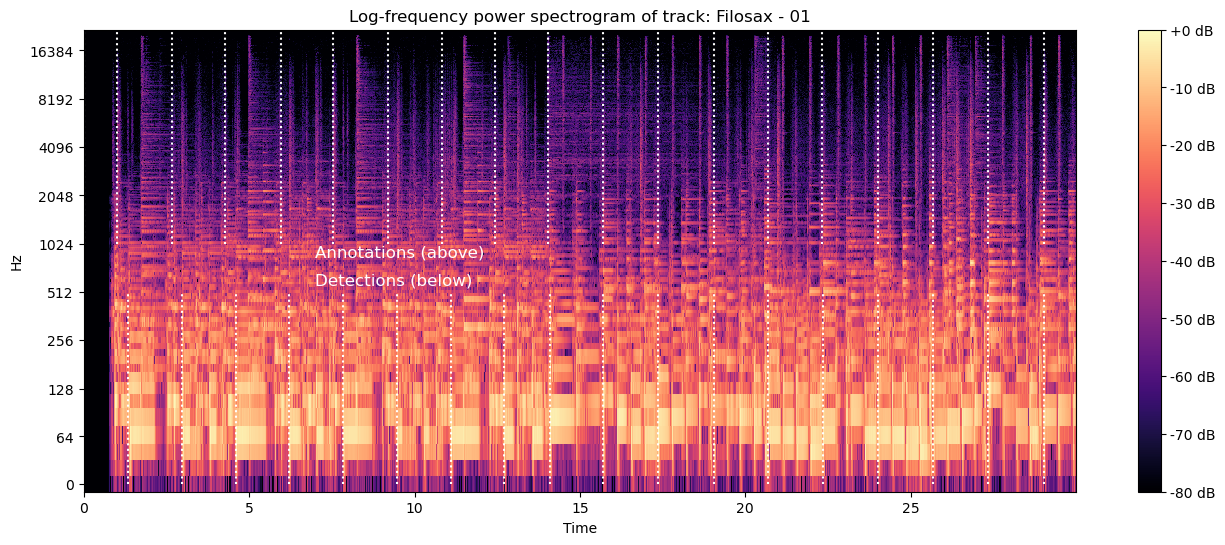

In [25]:
def visualize_downbeats(filename_: str,annotations_: np.array,predictions_: np.array, length:int = 30):
    '''
    Visualize predictions from madmom.
    filename: string, path to audio file (combined.wav)
    annotations: np.array, downbeat annotations from .jams file
    predictions: np.array, predictions from madmom 
    length: length of audio to visualize in seconds
    '''
    #load files
    
    audio,sr = sf.read(filename_)
    audio = audio[:sr*length]
    targets = annotations_[annotations_<length]
    predictions_ = predictions_[predictions_<length]
    name = os.path.basename(os.path.dirname(filename_))
    # make visualization
    hop_length = 512
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(audio, hop_length=hop_length)), ref=np.max)
    plt.figure(figsize=(16,6))
    librosa.display.specshow(spec, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time')
    plt.title(f'Log-frequency power spectrogram of track: Filosax - {name}')
    plt.colorbar(format="%+2.f dB")
    # plot annotations in the upper part
    plt.vlines(targets, hop_length * 2, sr / 2, linestyles='dotted', color='w')
    #plt.vlines(track.beats.times[track.beats.positions == 1], hop_length * 2, sr / 2, color='w')
    plt.text(7, hop_length * 1.65, 'Annotations (above)', color='w', fontsize=12)
    # plot detections in the lower part
    plt.vlines(predictions_, 0, hop_length, linestyles='dotted', color='w')
    #plt.vlines(predictions, 0, hop_length, color='w')
    plt.text(7, hop_length * 1.1, 'Detections (below)', color='w', fontsize=12)
    plt.show()
    
    
# make visualization   
visualize_downbeats("audio/filosax/Backing/01/combined.wav",np.asarray(annotations[0]),np.asarray(estimated_downbeats_[0]),30)

## Compare Transcriptions of PTI and MT-3 - MIDI Visualization
    * Load the midi-output of both PTI and MT-3 Transcription models of the same audio, and visualize for comparision 

In [9]:
logging.getLogger().setLevel(logging.CRITICAL)

multitrack = pypianoroll.read("audio/Test_44_pti.mid")
multitrack2 = pypianoroll.read("audio/Test_44_mt3.mid")
print(multitrack)

Multitrack(name=None, resolution=24, tempo=array(shape=(18168, 1), dtype=float64), downbeat=array(shape=(18168, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(18168, 128), dtype=uint8))])


In [10]:
multitrack.trim(0, 24 * multitrack.resolution)
multitrack2.trim(0,24 * multitrack2.resolution)

Multitrack(name=None, resolution=24, tempo=array(shape=(576, 1), dtype=float64), downbeat=array(shape=(576, 1), dtype=bool), tracks=[StandardTrack(name='', program=0, is_drum=False, pianoroll=array(shape=(576, 128), dtype=uint8))])

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

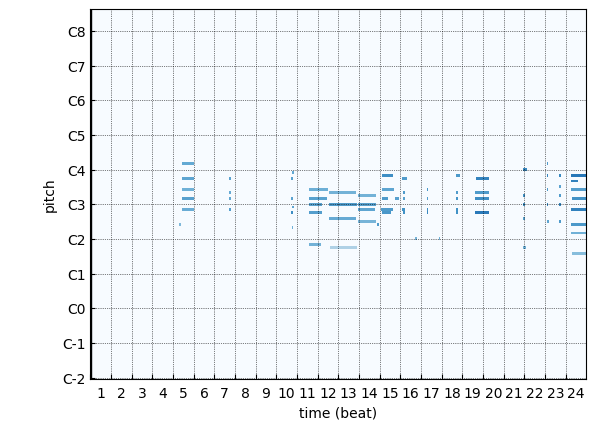

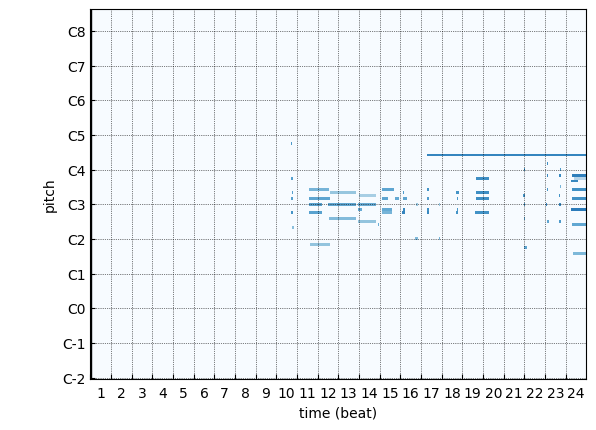

In [11]:
multitrack.plot()
multitrack2.plot()

## Plot your own midi:

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

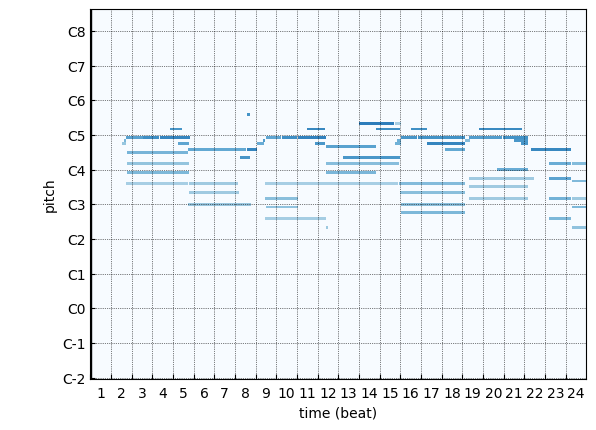

In [6]:
file_path_ = 'audio/out/jazz_piano001.mid'
multitrack_user = pypianoroll.read(file_path_)
multitrack_user.trim(0, 24 * multitrack_user.resolution)
multitrack_user.plot()
#execute twice 

## Load corresponding audio file

In [7]:
audio_path_ = 'audio/jazz_piano.mp3'
Audio(filename=audio_path_,rate=44100.)

In [5]:
SOUNDFONT = "GSv1.471.sf2" # path to soundfont file for midi to audio conversion
# load midi
midi_path = "audio/out/jazz_piano001.mid"
wave1, sr = midi_to_audio(midi_path,SOUNDFONT)
print(wave1.shape)
Audio(data=wave1,rate=sr)

ALSA lib conf.c:4004:(snd_config_hooks_call) Cannot open shared library libasound_module_conf_pulse.so (/home/seb/miniconda3/envs/practical/lib/alsa-lib/libasound_module_conf_pulse.so: cannot open shared object file: No such file or directory)
ALSA lib control.c:1528:(snd_ctl_open_noupdate) Invalid CTL hw:0


(1362105,)
